In [1]:
import numpy as np
import pandas as pd
from copy import deepcopy
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PowerTransformer, FunctionTransformer
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

In [2]:

RANDOM_STATE = 42
DF_PATH = "data/winequality-red_sep.csv"
SCORING = "accuracy"  # GridSearchCV metric
CV = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

In [3]:

df = pd.read_csv(DF_PATH)
X = df.drop("quality", axis=1)
y = df["quality"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)
feature_names = list(X.columns)
LABELS = np.sort(df["quality"].unique())


class IQRClipper(BaseEstimator, TransformerMixin):
    """Clip each feature using the IQR rule to reduce the impact of extreme values."""

    def __init__(self, factor: float = 1.5):
        self.factor = factor

    def fit(self, X, y=None):
        df_ = pd.DataFrame(X)
        q1 = df_.quantile(0.25)
        q3 = df_.quantile(0.75)
        iqr = q3 - q1
        self.lower_ = q1 - self.factor * iqr
        self.upper_ = q3 + self.factor * iqr
        return self

    def transform(self, X):
        df_ = pd.DataFrame(X)
        clipped = df_.clip(lower=self.lower_, upper=self.upper_, axis=1)
        return clipped.values


def make_column_selector(columns):
    """Return a transformer that keeps only the specified columns."""
    def _select(df):
        return pd.DataFrame(df)[columns]
    return FunctionTransformer(_select, validate=False)


def plot_conf_matrix(cm, labels, title):
    """Plot and display a confusion-matrix heatmap."""
    fig, ax = plt.subplots(figsize=(6, 5))
    im = ax.imshow(cm, interpolation="nearest", cmap="Blues")
    ax.figure.colorbar(im, ax=ax)
    ax.set(
        xticks=np.arange(len(labels)),
        yticks=np.arange(len(labels)),
        xticklabels=labels,
        yticklabels=labels,
        xlabel="Predicted label",
        ylabel="True label",
        title=title,
    )
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(
                j,
                i,
                format(cm[i, j], "d"),
                ha="center",
                va="center",
                color="white" if cm[i, j] > thresh else "black",
            )
    plt.tight_layout()
    plt.show()


def compute_metrics(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred, labels=LABELS)
    macro_f1 = f1_score(y_true, y_pred, labels=LABELS, average="macro")
    weighted_f1 = f1_score(y_true, y_pred, labels=LABELS, average="weighted")
    return macro_f1, weighted_f1, cm


def evaluate_simple(name, change, pipeline):
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    test_acc = accuracy_score(y_test, y_pred)
    macro_f1, weighted_f1, cm = compute_metrics(y_test, y_pred)
    result = {
        "Model": name,
        "Change": change,
        "Adopted": False,
        "CV_accuracy": np.nan,
        "Test_accuracy": test_acc,
        "Macro_F1": macro_f1,
        "Weighted_F1": weighted_f1,
        "Confusion_matrix": cm,
    }
    return pipeline, result


def evaluate_grid(name, change, pipeline, param_grid):
    grid = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grid,
        scoring=SCORING,
        cv=CV,
        n_jobs=-1,
        verbose=0,
    )
    grid.fit(X_train, y_train)
    best_est = grid.best_estimator_
    cv_acc = grid.best_score_
    y_pred = best_est.predict(X_test)
    test_acc = accuracy_score(y_test, y_pred)
    macro_f1, weighted_f1, cm = compute_metrics(y_test, y_pred)
    result = {
        "Model": name,
        "Change": change,
        "Adopted": False,
        "CV_accuracy": cv_acc,
        "Test_accuracy": test_acc,
        "Macro_F1": macro_f1,
        "Weighted_F1": weighted_f1,
        "Confusion_matrix": cm,
    }
    return best_est, result, grid


def adopt_if_better(candidate_pipeline, candidate_result, best_acc):
    adopted = candidate_result["Test_accuracy"] > best_acc
    candidate_result["Adopted"] = adopted
    if adopted:
        return candidate_pipeline, candidate_result["Test_accuracy"], candidate_result
    return None, best_acc, candidate_result


def get_preprocess_steps(pipeline):
    if not hasattr(pipeline, "steps"):
        return []
    return [(n, s) for n, s in pipeline.steps if n not in {"svc", "bag"}]


def find_corr_pairs(X_df, cols, threshold=0.5, top_k=5):
    """Select several highly correlated feature pairs from the training set to build interaction terms."""
    corr = X_df[cols].corr().abs()
    pairs = []
    for i in range(len(cols)):
        for j in range(i + 1, len(cols)):
            val = corr.iloc[i, j]
            if val >= threshold:
                pairs.append((val, cols[i], cols[j]))
    pairs = sorted(pairs, reverse=True)[:top_k]
    return [(a, b) for _, a, b in pairs]


def make_corr_adder(pairs):
    """Return a transformer that adds the product of highly correlated feature pairs as new features."""
    def _add(df):
        df_ = pd.DataFrame(df).copy()
        for a, b in pairs:
            new_name = f"{a}*{b}"
            df_[new_name] = df_[a] * df_[b]
        return df_
    return FunctionTransformer(_add, validate=False)


results = []

In [4]:
# =====================================
# Group A: 
# =====================================
# Model 1 – Baseline-RBF-raw
base_params = {"kernel": "rbf", "C": 1.0, "gamma": "scale", "class_weight": None}
pipe_m1 = Pipeline([("svc", SVC(**base_params))])
pipe_m1, res_m1 = evaluate_simple("Model 1", "Raw features + default RBF", pipe_m1)
best_pipeline = pipe_m1
best_acc = res_m1["Test_accuracy"]
res_m1["Adopted"] = True
results.append(res_m1)

In [5]:

# Model 2 – RBF + StandardScaler(only add standardization step)
pipe_m2 = Pipeline([("scaler", StandardScaler()), ("svc", SVC(**base_params))])
pipe_m2, res_m2 = evaluate_simple("Model 2", "StandardScaler + default RBF", pipe_m2)
new_best, best_acc, res_m2 = adopt_if_better(pipe_m2, res_m2, best_acc)
if new_best is not None:
    best_pipeline = new_best
results.append(res_m2)

In [6]:

# Model 3 – RBF + Scaler + Coarse Grid
preprocess_base = get_preprocess_steps(best_pipeline)
pipe_m3 = Pipeline(preprocess_base + [("svc", SVC(kernel="rbf"))])
coarse_grid = {
    "svc__C": [0.1, 0.3, 1, 3, 10, 100, 1000],
    "svc__gamma": [1, 0.3, 0.1, 0.03, 0.01, 0.001, "scale"],
}
best_m3, res_m3, grid_m3 = evaluate_grid(
    "Model 3",
    "Keep preprocessing unchanged + coarse grid over C/gamma",
    pipe_m3,
    coarse_grid,
)
new_best, best_acc, res_m3 = adopt_if_better(best_m3, res_m3, best_acc)
if new_best is not None:
    best_pipeline = new_best
coarse_best_params = grid_m3.best_params_
results.append(res_m3)

In [7]:

# Model 4 – RBF + Scaler + Fine Grid
# Narrow the range around the best value from the coarse grid
best_C = coarse_best_params.get("svc__C", 1.0)
best_gamma = coarse_best_params.get("svc__gamma", "scale")
if isinstance(best_gamma, str):
    fine_gamma = [best_gamma]
else:
    fine_gamma = [best_gamma / 2, best_gamma, best_gamma * 2]
fine_C = [best_C / 2, best_C, best_C * 2]
pipe_m4 = Pipeline(preprocess_base + [("svc", SVC(kernel="rbf"))])
fine_grid = {"svc__C": fine_C, "svc__gamma": fine_gamma}
best_m4, res_m4, grid_m4 = evaluate_grid(
    "Model 4",
    "Same preprocessing as baseline + fine local grid",
    pipe_m4,
    fine_grid,
)
new_best, best_acc, res_m4 = adopt_if_better(best_m4, res_m4, best_acc)
if new_best is not None:
    best_pipeline = new_best
results.append(res_m4)

In [8]:

# Model 5 – RBF + Scaler + Fine Grid + class_weight
current_preprocess = get_preprocess_steps(best_pipeline)
svc_params_m5 = grid_m4.best_estimator_.named_steps["svc"].get_params()
svc_params_m5["class_weight"] = "balanced"
pipe_m5 = Pipeline(current_preprocess + [("svc", SVC(**svc_params_m5))])
# Use the same grid as the current baseline(fine_grid)
best_m5, res_m5, _ = evaluate_grid(
    "Model 5",
    "Add class_weight=balanced on top of the baseline tuning grid",
    pipe_m5,
    fine_grid,
)
new_best, best_acc, res_m5 = adopt_if_better(best_m5, res_m5, best_acc)
if new_best is not None:
    best_pipeline = new_best
results.append(res_m5)

In [9]:

# =====================================
# Group B：distribution handling (skewness /outliers)
# =====================================
current_preprocess = get_preprocess_steps(best_pipeline)
current_svc = best_pipeline.named_steps["svc"]
current_svc_params = current_svc.get_params()
# If the class_weight dict contains unkown labels,force it to None to avoid warnings
cw = current_svc_params.get("class_weight")
if isinstance(cw, dict):
    valid_labels = set(np.unique(y_train))
    if not set(cw.keys()).issubset(valid_labels):
        current_svc_params["class_weight"] = None

# Model 6 – + PowerTransform (only add a non-linear transformation step)
pre_m6 = [("power", PowerTransformer(method="yeo-johnson"))] + deepcopy(current_preprocess)
pipe_m6 = Pipeline(pre_m6 + [("svc", SVC(**current_svc_params))])
best_m6, res_m6, _ = evaluate_grid(
    "Model 6",
    "PowerTransformer + keep everything else unchanged",
    pipe_m6,
    fine_grid,
)
new_best, best_acc, res_m6 = adopt_if_better(best_m6, res_m6, best_acc)
if new_best is not None:
    best_pipeline = new_best
results.append(res_m6)

In [10]:

# Model 7 – + IQRClipper（only add IQR clipping）
current_preprocess = get_preprocess_steps(best_pipeline)
current_svc = best_pipeline.named_steps["svc"]
current_svc_params = current_svc.get_params()
pre_m7 = [("iqr", IQRClipper())] + deepcopy(current_preprocess)
pipe_m7 = Pipeline(pre_m7 + [("svc", SVC(**current_svc_params))])
best_m7, res_m7, _ = evaluate_grid(
    "Model 7",
    "IQR clipping + keep everything else unchanged",
    pipe_m7,
    fine_grid,
)
new_best, best_acc, res_m7 = adopt_if_better(best_m7, res_m7, best_acc)
if new_best is not None:
    best_pipeline = new_best
results.append(res_m7)

In [11]:

# =====================================
# Group C：Kernel selection（only change the kernel）
# =====================================
current_preprocess = get_preprocess_steps(best_pipeline)
current_svc = best_pipeline.named_steps["svc"]
current_svc_params = current_svc.get_params()
# Clean up any potentially invalid class_weight dict
cw = current_svc_params.get("class_weight")
if isinstance(cw, dict):
    valid_labels = set(np.unique(y_train))
    if not set(cw.keys()).issubset(valid_labels):
        current_svc_params["class_weight"] = None
# Keep class_weight consistent with the current baseline; use a small per-kernel grid to avoid invalid params and reduce combinations
param_grid_kernel = [
    {  # linear only tune C
        "svc__kernel": ["linear"],
        "svc__C": [0.5, 1, 10],
        "svc__class_weight": [None, "balanced"],
    },
    {  # rbf tune C/gamma
        "svc__kernel": ["rbf"],
        "svc__C": [0.5, 1, 10],
        "svc__gamma": [0.1, 0.01, "scale"],
        "svc__class_weight": [None, "balanced"],
    },
    {  # poly tune C/gamma/degree
        "svc__kernel": ["poly"],
        "svc__C": [0.5, 1, 10],
        "svc__gamma": [0.01, "scale"],
        "svc__degree": [2, 3],
        "svc__class_weight": [None, "balanced"],
    },
]
pipe_m8 = Pipeline(current_preprocess + [("svc", SVC())])
best_m8, res_m8, _ = evaluate_grid(
    "Model 8",
    "Same preprocessing & tuning strategy;omly change the kernel",
    pipe_m8,
    param_grid_kernel,
)
new_best, best_acc, res_m8 = adopt_if_better(best_m8, res_m8, best_acc)
if new_best is not None:
    best_pipeline = new_best
results.append(res_m8)

In [12]:

# =====================================
# Group D1：PCA dimensionality reduction（only add PCA）
# =====================================
current_preprocess = get_preprocess_steps(best_pipeline)
current_svc = best_pipeline.named_steps["svc"]
current_svc_params = current_svc.get_params()

# Auto-generate candidate k from training-set cumulative variance; tune only this and keep other params fixed to the current best pipeline
if current_preprocess:
    pre_for_pca = Pipeline(current_preprocess)
    X_train_pre = pre_for_pca.fit_transform(X_train)
else:
    X_train_pre = X_train.values

pca_full = PCA()
pca_full.fit(X_train_pre)
cum_explained = pca_full.explained_variance_ratio_.cumsum()

def first_k_for_threshold(thr):
    meets = np.where(cum_explained >= thr)[0]
    return int(meets[0] + 1) if meets.size > 0 else len(cum_explained)

k90 = first_k_for_threshold(0.90)
k95 = first_k_for_threshold(0.95)

candidates_set = {k90, k95}
for delta in [-1, 1]:
    k = k90 + delta
    if 2 <= k <= len(cum_explained):
        candidates_set.add(k)
pca_candidates = sorted(c for c in candidates_set if 2 <= c <= len(cum_explained))
if not pca_candidates:
    pca_candidates = [min(5, len(cum_explained))]

pipe_m9 = Pipeline(current_preprocess + [("pca", PCA()), ("svc", SVC(**current_svc_params))])
param_grid_m9 = {"pca__n_components": pca_candidates}
best_m9, res_m9, _ = evaluate_grid(
    "Model 9",
    f"PCA dimensionality reduction(n_components ∈ {pca_candidates}), keep other parameters unchanged",
    pipe_m9,
    param_grid_m9,
)
new_best, best_acc, res_m9 = adopt_if_better(best_m9, res_m9, best_acc)
if new_best is not None:
    best_pipeline = new_best
results.append(res_m9)

In [13]:

# =====================================
# Group D2：Feature selection（only change the feature subset）
# =====================================
current_preprocess = get_preprocess_steps(best_pipeline)
current_svc = best_pipeline.named_steps["svc"]
current_svc_params = current_svc.get_params()
# Compute permutation importance using the current best pipeline
baseline_clone = deepcopy(best_pipeline)
baseline_clone.fit(X_train, y_train)
perm = permutation_importance(
    baseline_clone, X_train, y_train, n_repeats=5, random_state=RANDOM_STATE, scoring=SCORING
)
importances = perm.importances_mean
sorted_idx = np.argsort(importances)[::-1]

threshold_ratio = 0.2
max_imp = importances[sorted_idx[0]] if len(sorted_idx) > 0 else 0.0
selected_idx_thresh = [i for i in sorted_idx if importances[i] >= max_imp * threshold_ratio]
if len(selected_idx_thresh) == 0: 
    selected_idx_thresh = sorted_idx[: min(8, len(feature_names))]

corr_pairs = find_corr_pairs(X_train, feature_names, threshold=0.5, top_k=5)
corr_feature_names = [f"{a}*{b}" for a, b in corr_pairs]
corr_adder = make_corr_adder(corr_pairs) if corr_pairs else None

candidate_subsets = []

candidate_subsets.append(("thresh", [feature_names[i] for i in selected_idx_thresh]))

for k in [4, 6, 8, 10]:
    k = min(k, len(feature_names))
    candidate_subsets.append((f"top{k}", [feature_names[i] for i in sorted_idx[:k]]))

seen = set()
best_m9 = None
best_res_m9 = None
best_grid_acc = -np.inf

for label, cols in candidate_subsets:
    key = tuple(cols)
    if len(cols) == 0 or key in seen:
        continue
    seen.add(key)
    
    for use_corr in [False, True]:
        if use_corr and not corr_pairs:
            continue
        cols_used = cols if not use_corr else cols + corr_feature_names
        selector = make_column_selector(cols_used)
        pre_m9 = []
        if use_corr and corr_adder is not None:
            pre_m9.append(("corr", corr_adder))
        pre_m9.append(("select", selector))
        pre_m9 += deepcopy(current_preprocess)
        pipe_m9 = Pipeline(pre_m9 + [("svc", SVC(**current_svc_params))])
        label_tag = f"{label}+corr" if use_corr else label
        m9_candidate, res_candidate, _ = evaluate_grid(
            "Model 10",
            f"Feature selection",
            pipe_m9,
            fine_grid,
        )
        if res_candidate["Test_accuracy"] > best_grid_acc:
            best_grid_acc = res_candidate["Test_accuracy"]
            best_m9 = m9_candidate
            best_res_m9 = res_candidate

new_best, best_acc, res_m9_final = adopt_if_better(best_m9, best_res_m9, best_acc)
if new_best is not None:
    best_pipeline = new_best
results.append(res_m9_final)

In [14]:

# =====================================
# Group E：Ensemble（Bagging SVM）
# =====================================
current_preprocess = get_preprocess_steps(best_pipeline)
current_svc = best_pipeline.named_steps["svc"]
current_svc_params = current_svc.get_params()
# Simplified bagging：keep current best params; only tune the number of base estimators
pipe_m10 = Pipeline(
    current_preprocess
    + [
        (
            "bag",
            BaggingClassifier(
                estimator=SVC(**current_svc_params),
                bootstrap=True,
                n_jobs=-1,
                random_state=RANDOM_STATE,
                oob_score=False,
            ),
        )
    ]
)
param_grid_m10 = {
    "bag__n_estimators": [5, 10, 20, 30],
}
best_m10, res_m10, _ = evaluate_grid(
    "Model 11",
    "Bagging SVM (small grid to boosst diversity)",
    pipe_m10,
    param_grid_m10,
)
new_best, best_acc, res_m10 = adopt_if_better(best_m10, res_m10, best_acc)
if new_best is not None:
    best_pipeline = new_best
results.append(res_m10)

In [15]:

# ============== Summary ==============
summary_df = pd.DataFrame(results)
summary_df["Adopted"] = summary_df["Adopted"].map({True: "Yes", False: "No"})
display_cols = [
    "Model",
    "Change",
    "Adopted",
    "CV_accuracy",
    "Test_accuracy",
    "Macro_F1",
    "Weighted_F1",
]
fmt_num = lambda x: f"{x:20.4f}" 

formatters = {
    "CV_accuracy": fmt_num,
    "Test_accuracy": fmt_num,
    "Macro_F1": fmt_num,
    "Weighted_F1": fmt_num,
}
print("\n=== Summary (in order) ===")
print(summary_df[display_cols].to_string(index=False, formatters=formatters,col_space=20,justify="center"))

final_model = summary_df.loc[summary_df["Test_accuracy"].idxmax(), "Model"]
print(f"\n Final recommended model: {final_model}")


=== Summary (in order) ===
       Model                                                  Change                                               Adopted            CV_accuracy         Test_accuracy           Macro_F1           Weighted_F1     
       Model 1                                                                    Raw features + default RBF         Yes                           NaN               0.4813               0.1701               0.4194
       Model 2                                                                  StandardScaler + default RBF         Yes                           NaN               0.6250               0.2990               0.6023
       Model 3                                       Keep preprocessing unchanged + coarse grid over C/gamma         Yes                        0.6505               0.6531               0.3816               0.6397
       Model 4                                              Same preprocessing as baseline + fine local grid        


=== Confusion Matrices (rows=true, cols=pred) ===

Model 1
   3  4   5    6  7  8
3  0  0   0    2  0  0
4  0  0   1   10  0  0
5  0  0  47   89  0  0
6  0  0  21  107  0  0
7  0  0   4   36  0  0
8  0  0   0    3  0  0


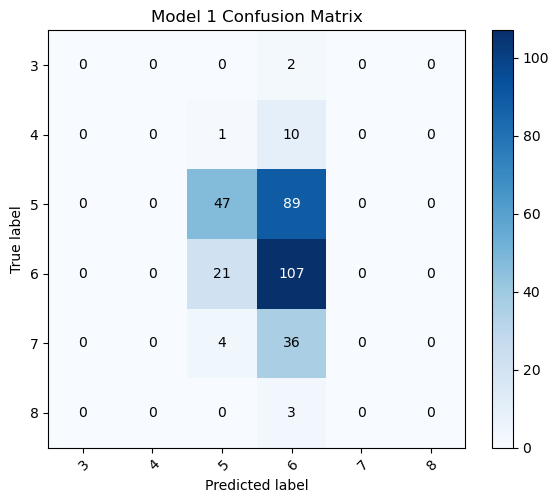


Model 2
   3  4    5   6   7  8
3  0  0    1   1   0  0
4  0  0   10   1   0  0
5  0  0  103  33   0  0
6  0  0   42  83   3  0
7  0  0    2  24  14  0
8  0  0    0   2   1  0


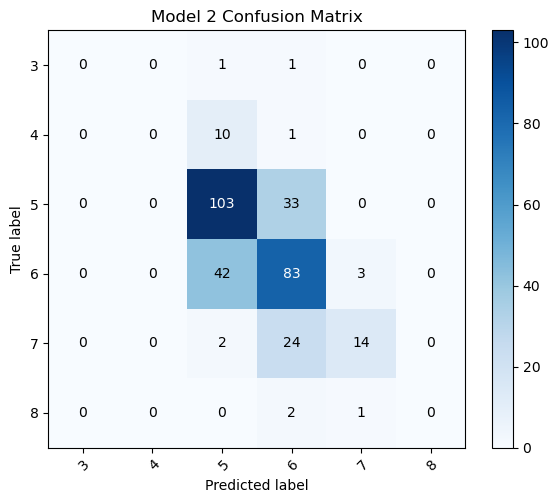


Model 3
   3  4   5   6   7  8
3  0  1   1   0   0  0
4  0  0   6   5   0  0
5  0  1  96  37   2  0
6  0  0  31  93   3  1
7  0  0   4  16  19  1
8  0  0   2   0   0  1


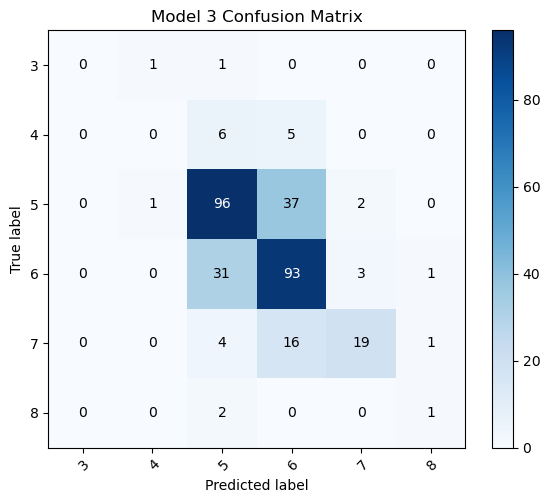


Model 4
   3  4   5   6   7  8
3  0  1   1   0   0  0
4  0  0   6   5   0  0
5  0  1  96  37   2  0
6  0  0  31  93   3  1
7  0  0   4  16  19  1
8  0  0   2   0   0  1


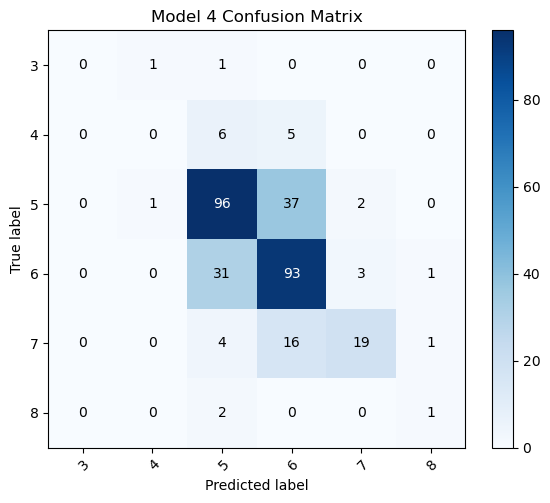


Model 5
   3  4   5   6   7  8
3  0  1   1   0   0  0
4  0  0   6   5   0  0
5  0  1  96  37   2  0
6  0  0  31  93   3  1
7  0  0   4  16  19  1
8  0  0   2   0   0  1


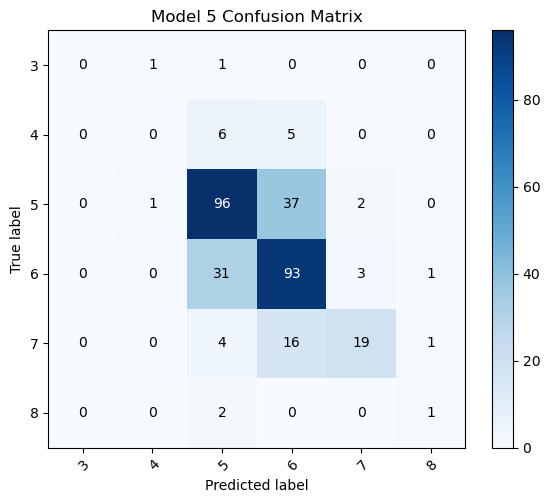


Model 6
   3  4    5    6   7  8
3  0  1    0    1   0  0
4  0  0    6    5   0  0
5  0  0  103   33   0  0
6  0  0   26  101   1  0
7  0  0    4   21  15  0
8  0  0    1    1   0  1


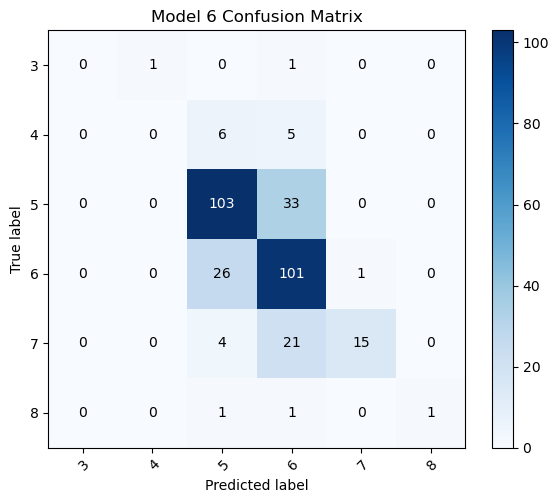


Model 7
   3  4    5    6   7  8
3  0  1    0    1   0  0
4  0  0    5    6   0  0
5  0  0  100   35   1  0
6  0  0   25  102   1  0
7  0  0    2   24  14  0
8  0  0    0    2   0  1


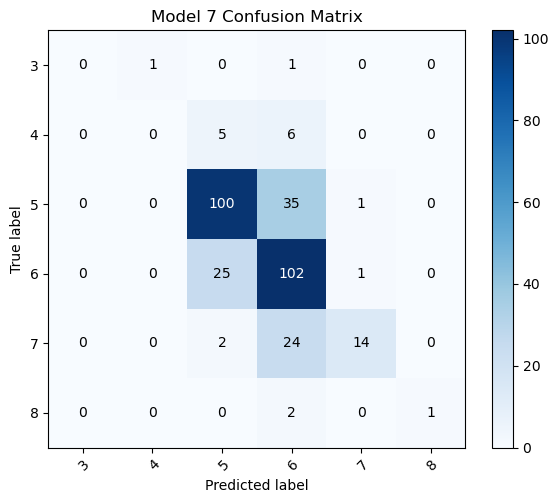


Model 8
   3  4   5   6   7  8
3  0  1   1   0   0  0
4  1  0   8   2   0  0
5  0  6  95  33   2  0
6  0  3  31  80  14  0
7  0  0   2  15  22  1
8  0  0   0   2   1  0


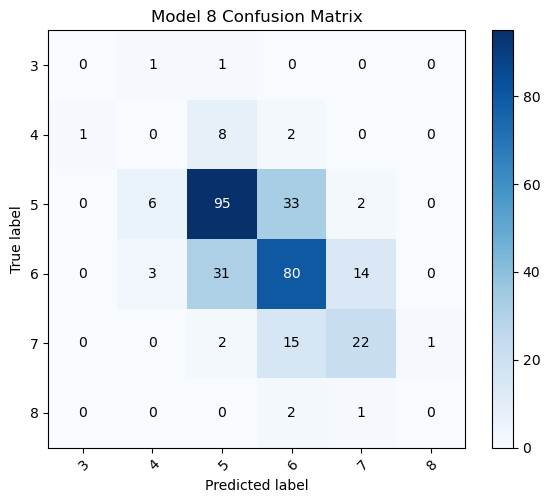


Model 9
   3  4   5   6   7  8
3  0  1   0   1   0  0
4  0  0   4   7   0  0
5  0  0  91  43   2  0
6  0  0  27  97   4  0
7  0  0   4  21  15  0
8  0  0   1   1   0  1


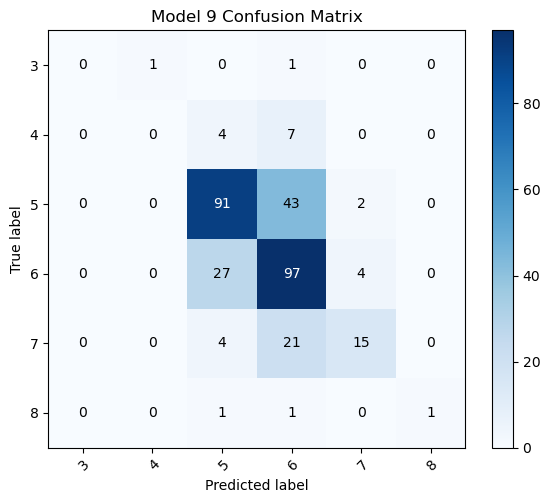


Model 10
   3  4    5    6   7  8
3  0  1    0    1   0  0
4  0  0    6    5   0  0
5  0  0  103   33   0  0
6  0  0   26  101   1  0
7  0  0    4   21  15  0
8  0  0    1    1   0  1


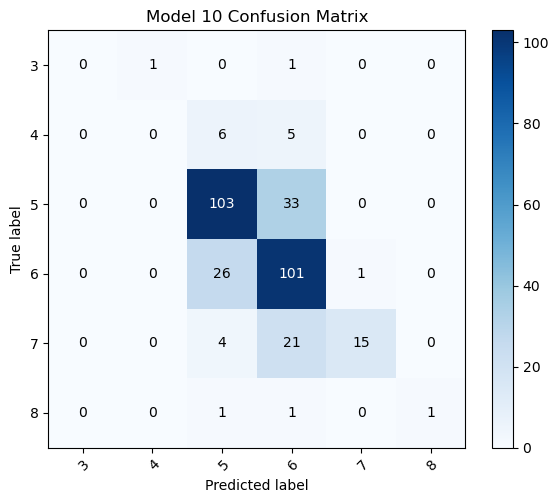


Model 11
   3  4    5   6   7  8
3  0  1    1   0   0  0
4  0  0    7   4   0  0
5  0  0  104  32   0  0
6  0  0   43  84   1  0
7  0  0    7  20  13  0
8  0  0    1   1   0  1


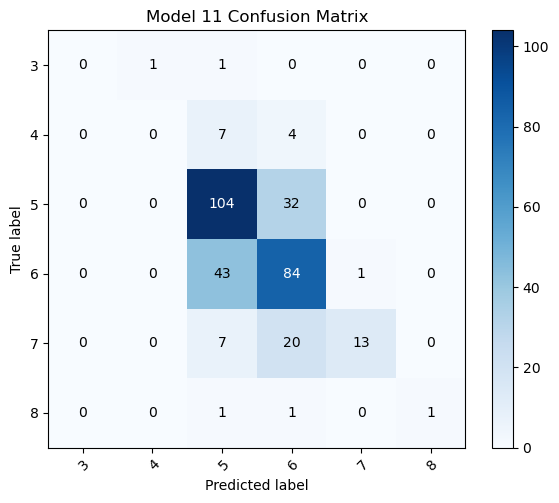

In [16]:

# ============== Confusion Matrices (Test Set) ==============
print("\n=== Confusion Matrices (rows=true, cols=pred) ===")
for res in results:
    if res is None:
        continue
    cm = res.get("Confusion_matrix")
    if cm is None:
        continue
    cm_df = pd.DataFrame(cm, index=LABELS, columns=LABELS)
    print(f"\n{res['Model']}")
    print(cm_df)
    plot_conf_matrix(cm, LABELS, title=f"{res['Model']} Confusion Matrix")